In [0]:
import pandas as pd
import numpy as np

import spacy
from torchtext import data
from torchtext import vocab

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

np.random.seed(7)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## 1. Prepare data and create torchtext dataset

**Load the dataset**

In [0]:
df = pd.read_csv('./peer-reviews.csv', error_bad_lines=False)

In [5]:
print(df.shape)
print(df.head())

(1451, 3)
  review_file_id                                           comments  score
0       729.json  strength propose kernel based method capture h...      3
1       338.json  strength related work quite thorough compariso...      3
2       343.json  strength well organized easy understand provid...      2
3       752.json  strength demonstrates seqseq model comparative...      3
4       752.json  self training train seqseq based parser using ...      3


** Check data distribution over classes and create class weights because of imbalanced data we have **

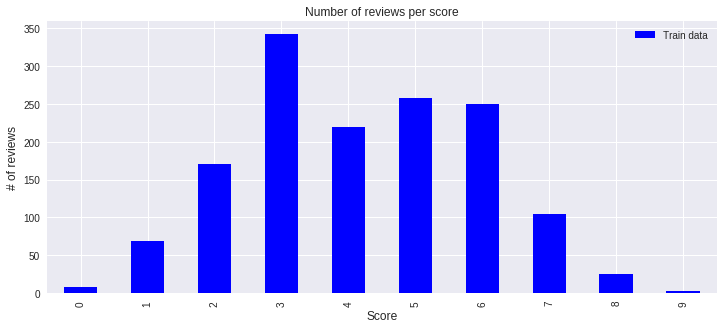

In [6]:
# Check the distribution of samples over labels in labeled data
df_stats = df.score.value_counts()

plt.figure(figsize=(12,5))
plt.title('Number of reviews per score')
ax1 = df_stats.sort_index(ascending=True).plot(color='blue', grid=True, label='Train data', kind='bar', legend=False)
ax1.legend(loc=1)
plt.ylabel('# of reviews', fontsize=12)
plt.xlabel('Score', fontsize=12)
plt.show()

In [7]:
np.unique(df.score)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

** Split the data **

In [10]:
train, test = train_test_split(df, test_size=0.25) # shuffle is default True


# Make sure that both sets include samples of 10 classes after the split. 
# Because of imbalanced data and because there are very few samples for some classes, 
# there are cases where after the split there are samples of a specific class missing in training or test set. 
print(np.unique(train.score))
print(np.unique(test.score))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


In [11]:
print(train.shape)
print(test.shape)

(1088, 3)
(363, 3)


In [12]:
train.to_csv('./train.csv', encoding='utf-8', index=False)
test.to_csv('./test.csv', encoding='utf-8', index=False) 

print("Done!")

Done!


**Generate class weights**

In [0]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train.score),
                                                 train.score)

In [14]:
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights

tensor([15.5429,  2.0528,  0.8500,  0.4090,  0.6758,  0.5523,  0.6147,  1.3600,
         6.4000, 54.4000])

** Tikenization **

In [0]:
# tokanize reviews
nlp = spacy.load('en', disable=['parser', 'tagger', 'ner'])
def tokenizer(s): 
    return [w.text.lower() for w in nlp(s)]

**Define fields**

In [0]:
# columns to be processed
comments_field = data.Field(sequential=True, 
                       tokenize=tokenizer,
                       include_lengths=True, 
                       use_vocab=True)

score_field = data.Field(sequential=False, 
                         use_vocab=False, 
                         pad_token=None, 
                         unk_token=None)

df_fields = [
    ('review_file_id', None), # get rid of it
    ('comments', comments_field), # process the comments field
    ('score', score_field) # process the score field
]

In [0]:
# Load datasets and create torchtext dataset
trainds, testds = data.TabularDataset.splits(path='./', 
                                            format='csv', 
                                            train='train.csv', 
                                            test='test.csv', 
                                            fields=df_fields, 
                                            skip_header=True)

In [18]:
type(trainds)

torchtext.data.dataset.TabularDataset

In [19]:
len(trainds), len(testds)

(1088, 363)

In [20]:
ex = trainds[0]
print(type(ex), '\n')
print(trainds.fields.items(), '\n')
print(ex.score, '\n')
print(ex.comments)

<class 'torchtext.data.example.Example'> 

dict_items([('review_file_id', None), ('comments', <torchtext.data.field.Field object at 0x7f5e8357cba8>), ('score', <torchtext.data.field.Field object at 0x7f5e8357cb70>)]) 

3 

['strength', 'clearly', 'written', 'well', 'structured', 'system', 'newly', 'applied', 'several', 'technique', 'including', 'global', 'optimization', 'neural', 'relation', 'extraction', 'direct', 'incorporation', 'parser', 'representation', 'interesting', 'proposed', 'system', 'achieved', 'state', 'performance', 'conll', 'data', 'set', 'include', 'several', 'analysis', 'weakness', 'approach', 'incremental', 'seems', 'like', 'combination', 'existing', 'method', 'improvement', 'performance', 'percent', 'point', 'relatively', 'small', 'significance', 'test', 'provided', 'general', 'discussion', 'major', 'comment', 'employed', 'recent', 'parser', 'glove', 'word', 'embeddings', 'affect', 'relation', 'extraction', 'performance', 'prediction', 'deal', 'illegal', 'prediction

## 2. Load pretrained word vectors and building vocabulary

In [21]:
# load glove embeddings
emb = vocab.Vectors('glove.6B.100d.txt', './datasets/embeddings/glove.6B/')

 99%|█████████▉| 397905/400000 [00:18<00:00, 21849.20it/s]

In [0]:
# build the vocabulary using both datasets (train and test) and assign the vectors
comments_field.build_vocab(trainds, testds, max_size=500000, vectors=emb)

In [23]:
comments_field.vocab.vectors.shape

torch.Size([10486, 100])

In [24]:
comments_field.vocab.vectors[comments_field.vocab.stoi['model']]

tensor([-0.2766,  0.5509,  0.1362,  0.5968, -0.2487, -0.3431,  0.7466,  0.1272,
        -0.2882,  0.7873, -0.0208, -0.4832,  0.2338, -0.0065,  0.3392,  0.0423,
         0.5448,  0.6058,  0.2729,  0.1301, -0.0439, -0.5136,  0.2555,  0.3305,
         0.4398, -0.2245,  0.0925, -1.2390, -0.5825,  0.2979,  0.1263,  1.3109,
        -0.2237, -0.1895,  0.8399,  0.3865,  0.4103, -0.0473,  0.3379, -0.4365,
        -0.1987, -0.3070,  0.1233,  0.2290, -0.3422,  0.1925,  0.1574, -0.3082,
        -0.3970,  0.0805, -0.2801,  0.0813,  0.1505,  1.3843,  0.3992, -1.9970,
        -0.7401,  0.5926,  1.0900, -0.1147,  0.0923,  0.3302, -0.6195,  0.6391,
         1.1857, -0.0426, -0.6086, -0.3032,  0.1685,  0.5659,  0.3666,  0.1214,
        -0.0610, -0.0578,  0.4706, -0.1027,  1.1243, -0.0266, -0.8119, -0.9424,
        -0.0934,  0.1509,  0.3441, -0.2411, -0.9204,  0.3470,  0.3965, -1.1369,
        -0.3357, -0.8408,  0.1644,  0.2124,  0.4047, -0.3580,  0.4828, -0.1103,
        -0.8110, -0.6382,  1.0284,  0.05

## 3. Loading the data in batches

BatchGenerator is an iterable wrapper around Batch Object that returns the desired data. 
BucketIterator returns a Batch object instead of text index and labels directly and Batch object is not iterable unlike pytorch Dataloader. A single Batch object contains the data of one batch and the text and labels can be accessed via column names. This is one of the small hiccups in torchtext, therefore BatchGenerator wrapper helps here.

In [0]:
class BatchGenerator:
    def __init__(self, dl, x_field, y_field):
        self.dl, self.x_field, self.y_field = dl, x_field, y_field
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_field)
            yield (X,y)

In [0]:
# Create the iterator
traindl, testdl = data.BucketIterator.splits(
                                                datasets=(trainds, testds), 
                                                batch_sizes=(8,8), 
                                                sort_key=lambda x: len(x.comments), 
                                                device=None, 
                                                sort_within_batch=True
                                            )

train_batches = BatchGenerator(traindl, 'comments', 'score')
val_batches = BatchGenerator(testdl, 'comments', 'score')

In [27]:
len(train_batches), len(val_batches)

(136, 46)

In [28]:
train_batches = BatchGenerator(traindl, 'comments', 'score')
next(iter(train_batches))

((tensor([[ 432,   10, 2129,   11,  211, 1083, 4635,   21],
          [ 126,  451, 1170,   81,   11,   32,  318,   45],
          [  40,   55,  495,   11,   32,  304,  127,  440],
          [  17, 1186,  485,  118, 4264,   16,  533, 1392],
          [ 596,  305,  689,    3,   67, 2152,  474,   76],
          [2657,  645,  393,   14,  110,  304,   62,   72],
          [1383,   16,  446, 5476,  487,   16,  273,  281],
          [  25,  863,   45,  970, 4247,  138,   31,  830],
          [   7,   23,  160,  135,   48,   23,    4, 4405],
          [ 995, 4181,  410, 1907,  151,   89,  202, 1813],
          [4919,   12, 3959,  392,  725,  106,  604, 1122],
          [ 904,  111,  160,  128,    9,   58,  912,   63],
          [ 359,  555,   78,  142,  329,   11,   76,   45],
          [ 624,  131,  437,  689,  152,   81, 1258,  440],
          [ 737, 2508, 2021,   16,   16,  238, 1043, 1616],
          [ 123,  320,   31,  946, 3089,  283, 2518,  470],
          [ 170,  795,    4, 2437,    4,

## 4. Model and training

**LSTM model**

In [0]:
class RNN(nn.Module):
    def __init__(   
                    self, 
                    vocab_size, 
                    embedding_dim,
                    pretrained_embeddings,
                    num_output=10, 
                    hidden_size=32, 
                    num_layers=1
                ):

        super(RNN, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.pretrained_embeddings = pretrained_embeddings
        self.num_output = num_output
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Embedding layer. Replace the initial weights of the embedding layer with the pre-trained embeddings.
        self.encoder = nn.Embedding(self.vocab_size, self.embedding_dim, _weight=self.pretrained_embeddings)
        self.encoder.weight.requires_grad = False
        
        # Dropout
        self.dropout = nn.Dropout(p = 0.7)
        
        # LSTM
        self.lstm = nn.LSTM(
                                input_size = self.embedding_dim, 
                                hidden_size = self.hidden_size, 
                                num_layers = self.num_layers
                            )
        
        # Output
        self.out = nn.Linear(self.hidden_size, self.num_output)
    
    def attention_unit(self, lstm_output, final_state):

        """ 
        Let's add Attention mechanism in the LSTM model. 
        Use attention to compute soft alignment score corresponding 
        between each of the hidden_state and the last hidden_state of the LSTM. 
        Use torch.bmm for the batch matrix multiplication.

        Arguments
        ---------

        lstm_output : Final output of the LSTM which contains hidden layer outputs for each sequence.
        final_state : Final time-step hidden state (h_n) of the LSTM

        ---------

        Returns : It performs attention mechanism by first computing weights for each of the sequence present 
        in lstm_output and then finally computing the new hidden state.

        Tensor Size :
            hidden.size() = (batch_size, hidden_size)
            attn_weights.size() = (batch_size, num_seq)
            soft_attn_weights.size() = (batch_size, num_seq)
            new_hidden_state.size() = (batch_size, hidden_size)

        """
        hidden = final_state.squeeze(0)
        attn_weights = torch.bmm(lstm_output, hidden.unsqueeze(2)).squeeze(2)
        soft_attn_weights = F.softmax(attn_weights, 1)
        new_hidden_state = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)

        # print('hidden', hidden.size())
        # print('attn_weights', attn_weights.size())
        # print('soft_attn_weights', soft_attn_weights.size())
        # print('new_hidden_state', new_hidden_state.size())
        
        return new_hidden_state
    
    def forward(self, x, seq_lengths):

        # x.shape => (batch_size, sequence_length)
        batch_size = x.size(1)

        # Make hidden
        hidden = self.init_hidden(batch_size)

        # Make embs ... x_embed.shape => (x, batch_size, embedding_dim)
        x_embed = self.encoder(x)
        
        # Drop some nodes
        # x_embed = self.dropout(x_embed)
        
        # Handling padding
        x_embed_packed = pack_padded_sequence(x_embed, seq_lengths) 
        output, (hidden_final, cell_final) = self.lstm(x_embed_packed, hidden) # hidden_final.size() = (1, batch_size, hidden_size) 
            
        # LSTM WITHOUT ATTENTION
        # No need to unpack, since we are going to use the hidden only
        # Use the last hidden layer output as fc's input
        fc_output = self.out(hidden_final[-1])

        # LSTM WITH ATTENTION
        # We need to unpack
        # output, _ = pad_packed_sequence(output, batch_first=True) # ouput.size() = (batch_size, num_seq, hidden_size)
        # attn_output = self.attention_unit(output, hidden_final) 
        # fc_output = self.out(attn_output)
            
        return fc_output

    def init_hidden(self, batch_size):
        
        h_0 = Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size))
        
        return (h_0, c_0)

**Traing function**

In [0]:
# Train cycle
def train(model, train_dl, criterion, optimizer):
    num_batch = len(train_dl)
    total_loss = 0
    y_true_train = list()
    y_pred_train = list()
    
    model.train()

    t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
    for (input, seq_lengths), target in t:
        
        pred = model(input, seq_lengths)
        
        loss = criterion(pred, target)
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred_idx = torch.max(pred, dim=1)[1]

        y_true_train += list(target.cpu().data.numpy())
        y_pred_train += list(pred_idx.cpu().data.numpy())
        
    train_acc = accuracy_score(y_true_train, y_pred_train)
    train_loss = total_loss/num_batch

    return train_loss, train_acc

In [0]:
# validation cycle
def validation(model, val_batches, criterion):
    num_batch = len(val_batches)
    total_loss = 0    
    y_true_val = list()
    y_pred_val = list()
    loss_history = []
    
    model.eval()

    with torch.no_grad():
        t = tqdm_notebook(iter(val_batches), leave=False, total=num_batch)
        for (input, seq_lengths), target in t:

            pred = model(input, seq_lengths)

            loss = criterion(pred, target)
                        
            total_loss += loss.item()
            loss_history.append(loss.item())

            pred_idx = torch.max(pred, dim=1)[1]
            y_true_val += list(target.cpu().data.numpy())
            y_pred_val += list(pred_idx.cpu().data.numpy())
            
        val_acc = accuracy_score(y_true_val, y_pred_val)
        val_loss = total_loss/num_batch
    
    return val_loss, val_acc

In [0]:
# test cycle
def test(model, val_batches, criterion):
    num_batch = len(val_batches)
    total_loss = 0    
    y_true_val = list()
    y_pred_val = list()
    loss_history = []
    
    with torch.no_grad():
        t = tqdm_notebook(iter(val_batches), leave=False, total=num_batch)
        for (input, seq_lengths), target in t:

            pred = model(input, seq_lengths)

            loss = criterion(pred, target)
                        
            total_loss += loss.item()
            loss_history.append(loss.item())

            pred_idx = torch.max(pred, dim=1)[1]
            y_true_val += list(target.cpu().data.numpy())
            y_pred_val += list(pred_idx.cpu().data.numpy())
            
        val_acc = accuracy_score(y_true_val, y_pred_val)
        val_loss = total_loss/num_batch
        
        cm = confusion_matrix(y_true_val, y_pred_val)
        scores = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=scores, yticklabels=scores)
        plt.xlabel('true label')
        plt.ylabel('predicted label')
        plt.show()
        
        print('Classification report: \n', classification_report(y_true_val, y_pred_val))
        
    return val_loss, val_acc

**Hyperparameters**

In [0]:
pretrained_embeddings = trainds.fields['comments'].vocab.vectors
vocab_size = len(comments_field.vocab)
embedding_dim = emb.dim
hidden_size = 32
num_output = 10
num_layers = 1

**Init model, optimizer and loss function**

In [0]:
model = RNN(
                    vocab_size = vocab_size, 
                    embedding_dim = embedding_dim, 
                    pretrained_embeddings = pretrained_embeddings,
                    num_output = num_output, 
                    hidden_size = hidden_size, 
                    num_layers = num_layers
                )

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight = class_weights) # weight = class_weights

**Train the model**

Training for, 250  epochs...
Embeddings dim:  100
Batch size:  8
Hidden size:  32
Layers:  1 



Exception ignored in: <bound method tqdm.__del__ of  99%|█████████▉| 397905/400000 [03:18<00:00, 21849.20it/s]>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 931, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 1133, in close
    self._decr_instances(self)
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 496, in _decr_instances
    cls.monitor.exit()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py", line 52, in exit
    self.join()
  File "/usr/lib/python3.6/threading.py", line 1053, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread


| Epoch: 01 | Train Loss: 2.278 | Train Acc: 10.39% | Valid Loss: 2.283 | Valid Acc: 9.92%


| Epoch: 02 | Train Loss: 2.274 | Train Acc: 10.48% | Valid Loss: 2.280 | Valid Acc: 9.92%


| Epoch: 03 | Train Loss: 2.272 | Train Acc: 10.39% | Valid Loss: 2.277 | Valid Acc: 9.64%


| Epoch: 04 | Train Loss: 2.268 | Train Acc: 10.75% | Valid Loss: 2.274 | Valid Acc: 9.92%


| Epoch: 05 | Train Loss: 2.264 | Train Acc: 10.66% | Valid Loss: 2.272 | Valid Acc: 9.92%


| Epoch: 06 | Train Loss: 2.263 | Train Acc: 10.66% | Valid Loss: 2.269 | Valid Acc: 10.47%


| Epoch: 07 | Train Loss: 2.261 | Train Acc: 10.48% | Valid Loss: 2.267 | Valid Acc: 10.74%


| Epoch: 08 | Train Loss: 2.257 | Train Acc: 11.40% | Valid Loss: 2.264 | Valid Acc: 10.47%


| Epoch: 09 | Train Loss: 2.255 | Train Acc: 11.21% | Valid Loss: 2.262 | Valid Acc: 10.47%


| Epoch: 10 | Train Loss: 2.252 | Train Acc: 11.12% | Valid Loss: 2.260 | Valid Acc: 11.02%


| Epoch: 11 | Train Loss: 2.250 | Train Acc: 11.76% | Valid Loss: 2.258 | Valid Acc: 11.02%


| Epoch: 12 | Train Loss: 2.247 | Train Acc: 12.13% | Valid Loss: 2.256 | Valid Acc: 11.85%


| Epoch: 13 | Train Loss: 2.247 | Train Acc: 12.13% | Valid Loss: 2.255 | Valid Acc: 12.12%


| Epoch: 14 | Train Loss: 2.243 | Train Acc: 12.87% | Valid Loss: 2.253 | Valid Acc: 12.67%


| Epoch: 15 | Train Loss: 2.243 | Train Acc: 12.04% | Valid Loss: 2.251 | Valid Acc: 12.40%


| Epoch: 16 | Train Loss: 2.239 | Train Acc: 12.50% | Valid Loss: 2.249 | Valid Acc: 13.50%


| Epoch: 17 | Train Loss: 2.238 | Train Acc: 12.78% | Valid Loss: 2.248 | Valid Acc: 13.77%


| Epoch: 18 | Train Loss: 2.236 | Train Acc: 12.59% | Valid Loss: 2.246 | Valid Acc: 14.33%


| Epoch: 19 | Train Loss: 2.233 | Train Acc: 13.42% | Valid Loss: 2.245 | Valid Acc: 14.33%


| Epoch: 20 | Train Loss: 2.229 | Train Acc: 13.97% | Valid Loss: 2.243 | Valid Acc: 15.70%


| Epoch: 21 | Train Loss: 2.231 | Train Acc: 15.07% | Valid Loss: 2.242 | Valid Acc: 15.15%


| Epoch: 22 | Train Loss: 2.229 | Train Acc: 15.62% | Valid Loss: 2.241 | Valid Acc: 15.70%


| Epoch: 23 | Train Loss: 2.226 | Train Acc: 16.64% | Valid Loss: 2.239 | Valid Acc: 16.25%


| Epoch: 24 | Train Loss: 2.226 | Train Acc: 17.37% | Valid Loss: 2.238 | Valid Acc: 16.25%


| Epoch: 25 | Train Loss: 2.225 | Train Acc: 16.91% | Valid Loss: 2.237 | Valid Acc: 16.80%


| Epoch: 26 | Train Loss: 2.222 | Train Acc: 17.56% | Valid Loss: 2.236 | Valid Acc: 17.36%


| Epoch: 27 | Train Loss: 2.224 | Train Acc: 17.74% | Valid Loss: 2.235 | Valid Acc: 16.80%


| Epoch: 28 | Train Loss: 2.221 | Train Acc: 18.84% | Valid Loss: 2.234 | Valid Acc: 17.08%


| Epoch: 29 | Train Loss: 2.218 | Train Acc: 19.58% | Valid Loss: 2.233 | Valid Acc: 18.18%


| Epoch: 30 | Train Loss: 2.218 | Train Acc: 19.67% | Valid Loss: 2.232 | Valid Acc: 18.73%


| Epoch: 31 | Train Loss: 2.216 | Train Acc: 20.04% | Valid Loss: 2.231 | Valid Acc: 19.28%


| Epoch: 32 | Train Loss: 2.213 | Train Acc: 20.13% | Valid Loss: 2.230 | Valid Acc: 20.66%


| Epoch: 33 | Train Loss: 2.215 | Train Acc: 20.59% | Valid Loss: 2.229 | Valid Acc: 20.11%


| Epoch: 34 | Train Loss: 2.209 | Train Acc: 20.22% | Valid Loss: 2.228 | Valid Acc: 19.56%


| Epoch: 35 | Train Loss: 2.213 | Train Acc: 20.59% | Valid Loss: 2.228 | Valid Acc: 19.01%


| Epoch: 36 | Train Loss: 2.213 | Train Acc: 21.05% | Valid Loss: 2.227 | Valid Acc: 19.01%


| Epoch: 37 | Train Loss: 2.210 | Train Acc: 21.14% | Valid Loss: 2.226 | Valid Acc: 19.28%


| Epoch: 38 | Train Loss: 2.210 | Train Acc: 21.60% | Valid Loss: 2.225 | Valid Acc: 19.28%


| Epoch: 39 | Train Loss: 2.209 | Train Acc: 22.15% | Valid Loss: 2.225 | Valid Acc: 19.83%


| Epoch: 40 | Train Loss: 2.208 | Train Acc: 21.78% | Valid Loss: 2.224 | Valid Acc: 20.39%


| Epoch: 41 | Train Loss: 2.209 | Train Acc: 21.60% | Valid Loss: 2.223 | Valid Acc: 20.11%


| Epoch: 42 | Train Loss: 2.205 | Train Acc: 22.15% | Valid Loss: 2.223 | Valid Acc: 20.94%


| Epoch: 43 | Train Loss: 2.204 | Train Acc: 21.88% | Valid Loss: 2.222 | Valid Acc: 20.66%


| Epoch: 44 | Train Loss: 2.208 | Train Acc: 22.70% | Valid Loss: 2.221 | Valid Acc: 20.94%


| Epoch: 45 | Train Loss: 2.206 | Train Acc: 22.61% | Valid Loss: 2.221 | Valid Acc: 20.66%


| Epoch: 46 | Train Loss: 2.197 | Train Acc: 22.15% | Valid Loss: 2.220 | Valid Acc: 20.39%


| Epoch: 47 | Train Loss: 2.205 | Train Acc: 22.98% | Valid Loss: 2.220 | Valid Acc: 20.66%


| Epoch: 48 | Train Loss: 2.201 | Train Acc: 22.98% | Valid Loss: 2.219 | Valid Acc: 20.94%


| Epoch: 49 | Train Loss: 2.200 | Train Acc: 23.25% | Valid Loss: 2.219 | Valid Acc: 20.66%


| Epoch: 50 | Train Loss: 2.199 | Train Acc: 23.35% | Valid Loss: 2.218 | Valid Acc: 20.66%


| Epoch: 51 | Train Loss: 2.197 | Train Acc: 23.62% | Valid Loss: 2.218 | Valid Acc: 20.94%


| Epoch: 52 | Train Loss: 2.196 | Train Acc: 22.98% | Valid Loss: 2.217 | Valid Acc: 20.66%


| Epoch: 53 | Train Loss: 2.203 | Train Acc: 23.71% | Valid Loss: 2.217 | Valid Acc: 20.94%


| Epoch: 54 | Train Loss: 2.201 | Train Acc: 23.62% | Valid Loss: 2.217 | Valid Acc: 21.49%


| Epoch: 55 | Train Loss: 2.196 | Train Acc: 24.17% | Valid Loss: 2.216 | Valid Acc: 21.76%


| Epoch: 56 | Train Loss: 2.196 | Train Acc: 23.90% | Valid Loss: 2.216 | Valid Acc: 21.49%


| Epoch: 57 | Train Loss: 2.198 | Train Acc: 23.62% | Valid Loss: 2.215 | Valid Acc: 21.21%


| Epoch: 58 | Train Loss: 2.197 | Train Acc: 24.26% | Valid Loss: 2.215 | Valid Acc: 21.49%


| Epoch: 59 | Train Loss: 2.197 | Train Acc: 23.53% | Valid Loss: 2.215 | Valid Acc: 21.49%


| Epoch: 60 | Train Loss: 2.197 | Train Acc: 23.44% | Valid Loss: 2.214 | Valid Acc: 21.49%


| Epoch: 61 | Train Loss: 2.190 | Train Acc: 23.62% | Valid Loss: 2.214 | Valid Acc: 21.49%


| Epoch: 62 | Train Loss: 2.198 | Train Acc: 23.71% | Valid Loss: 2.213 | Valid Acc: 21.76%


| Epoch: 63 | Train Loss: 2.194 | Train Acc: 23.53% | Valid Loss: 2.213 | Valid Acc: 21.21%


| Epoch: 64 | Train Loss: 2.193 | Train Acc: 23.07% | Valid Loss: 2.213 | Valid Acc: 21.76%


| Epoch: 65 | Train Loss: 2.188 | Train Acc: 23.81% | Valid Loss: 2.212 | Valid Acc: 21.76%


| Epoch: 66 | Train Loss: 2.190 | Train Acc: 23.07% | Valid Loss: 2.212 | Valid Acc: 21.49%


| Epoch: 67 | Train Loss: 2.192 | Train Acc: 23.16% | Valid Loss: 2.212 | Valid Acc: 21.21%


| Epoch: 68 | Train Loss: 2.187 | Train Acc: 23.16% | Valid Loss: 2.212 | Valid Acc: 21.21%


| Epoch: 69 | Train Loss: 2.193 | Train Acc: 23.53% | Valid Loss: 2.211 | Valid Acc: 21.49%


| Epoch: 70 | Train Loss: 2.189 | Train Acc: 23.25% | Valid Loss: 2.211 | Valid Acc: 21.21%


| Epoch: 71 | Train Loss: 2.188 | Train Acc: 23.53% | Valid Loss: 2.211 | Valid Acc: 21.21%


| Epoch: 72 | Train Loss: 2.191 | Train Acc: 23.53% | Valid Loss: 2.211 | Valid Acc: 21.76%


| Epoch: 73 | Train Loss: 2.187 | Train Acc: 23.62% | Valid Loss: 2.211 | Valid Acc: 21.76%


| Epoch: 74 | Train Loss: 2.187 | Train Acc: 23.35% | Valid Loss: 2.210 | Valid Acc: 22.31%


| Epoch: 75 | Train Loss: 2.191 | Train Acc: 23.62% | Valid Loss: 2.210 | Valid Acc: 21.76%


| Epoch: 76 | Train Loss: 2.182 | Train Acc: 23.53% | Valid Loss: 2.210 | Valid Acc: 22.31%


| Epoch: 77 | Train Loss: 2.186 | Train Acc: 23.99% | Valid Loss: 2.210 | Valid Acc: 21.76%


| Epoch: 78 | Train Loss: 2.190 | Train Acc: 24.26% | Valid Loss: 2.209 | Valid Acc: 21.76%


| Epoch: 79 | Train Loss: 2.187 | Train Acc: 24.36% | Valid Loss: 2.209 | Valid Acc: 21.49%


| Epoch: 80 | Train Loss: 2.185 | Train Acc: 23.90% | Valid Loss: 2.209 | Valid Acc: 21.49%


| Epoch: 81 | Train Loss: 2.182 | Train Acc: 23.90% | Valid Loss: 2.209 | Valid Acc: 21.49%


| Epoch: 82 | Train Loss: 2.189 | Train Acc: 23.53% | Valid Loss: 2.209 | Valid Acc: 21.76%


| Epoch: 83 | Train Loss: 2.181 | Train Acc: 23.99% | Valid Loss: 2.208 | Valid Acc: 22.04%


| Epoch: 84 | Train Loss: 2.186 | Train Acc: 24.08% | Valid Loss: 2.208 | Valid Acc: 21.76%


| Epoch: 85 | Train Loss: 2.187 | Train Acc: 23.90% | Valid Loss: 2.208 | Valid Acc: 21.49%


| Epoch: 86 | Train Loss: 2.181 | Train Acc: 24.45% | Valid Loss: 2.208 | Valid Acc: 21.49%


| Epoch: 87 | Train Loss: 2.184 | Train Acc: 24.08% | Valid Loss: 2.208 | Valid Acc: 21.21%


| Epoch: 88 | Train Loss: 2.182 | Train Acc: 24.08% | Valid Loss: 2.208 | Valid Acc: 21.49%


| Epoch: 89 | Train Loss: 2.178 | Train Acc: 23.53% | Valid Loss: 2.208 | Valid Acc: 20.94%


| Epoch: 90 | Train Loss: 2.180 | Train Acc: 24.17% | Valid Loss: 2.207 | Valid Acc: 21.49%


| Epoch: 91 | Train Loss: 2.182 | Train Acc: 23.90% | Valid Loss: 2.207 | Valid Acc: 20.94%


| Epoch: 92 | Train Loss: 2.185 | Train Acc: 23.90% | Valid Loss: 2.207 | Valid Acc: 20.94%


| Epoch: 93 | Train Loss: 2.183 | Train Acc: 24.08% | Valid Loss: 2.207 | Valid Acc: 20.94%


| Epoch: 94 | Train Loss: 2.186 | Train Acc: 24.26% | Valid Loss: 2.207 | Valid Acc: 20.94%


| Epoch: 95 | Train Loss: 2.181 | Train Acc: 23.99% | Valid Loss: 2.207 | Valid Acc: 22.04%


| Epoch: 96 | Train Loss: 2.184 | Train Acc: 24.63% | Valid Loss: 2.206 | Valid Acc: 21.76%


| Epoch: 97 | Train Loss: 2.181 | Train Acc: 24.26% | Valid Loss: 2.206 | Valid Acc: 21.21%


| Epoch: 98 | Train Loss: 2.182 | Train Acc: 24.36% | Valid Loss: 2.206 | Valid Acc: 21.49%


| Epoch: 99 | Train Loss: 2.177 | Train Acc: 24.17% | Valid Loss: 2.206 | Valid Acc: 21.49%


| Epoch: 100 | Train Loss: 2.182 | Train Acc: 24.17% | Valid Loss: 2.206 | Valid Acc: 21.49%


| Epoch: 101 | Train Loss: 2.179 | Train Acc: 24.36% | Valid Loss: 2.206 | Valid Acc: 21.76%


| Epoch: 102 | Train Loss: 2.181 | Train Acc: 24.72% | Valid Loss: 2.206 | Valid Acc: 21.76%


| Epoch: 103 | Train Loss: 2.177 | Train Acc: 24.54% | Valid Loss: 2.206 | Valid Acc: 21.76%


| Epoch: 104 | Train Loss: 2.181 | Train Acc: 24.17% | Valid Loss: 2.206 | Valid Acc: 21.76%


| Epoch: 105 | Train Loss: 2.174 | Train Acc: 24.45% | Valid Loss: 2.206 | Valid Acc: 21.76%


| Epoch: 106 | Train Loss: 2.179 | Train Acc: 24.26% | Valid Loss: 2.205 | Valid Acc: 21.21%


| Epoch: 107 | Train Loss: 2.173 | Train Acc: 24.26% | Valid Loss: 2.205 | Valid Acc: 21.49%


| Epoch: 108 | Train Loss: 2.178 | Train Acc: 24.26% | Valid Loss: 2.205 | Valid Acc: 21.76%


| Epoch: 109 | Train Loss: 2.182 | Train Acc: 24.45% | Valid Loss: 2.205 | Valid Acc: 21.76%


| Epoch: 110 | Train Loss: 2.177 | Train Acc: 24.36% | Valid Loss: 2.205 | Valid Acc: 21.49%


| Epoch: 111 | Train Loss: 2.179 | Train Acc: 24.63% | Valid Loss: 2.205 | Valid Acc: 21.76%


| Epoch: 112 | Train Loss: 2.173 | Train Acc: 24.45% | Valid Loss: 2.205 | Valid Acc: 21.76%


| Epoch: 113 | Train Loss: 2.177 | Train Acc: 24.36% | Valid Loss: 2.205 | Valid Acc: 21.76%


| Epoch: 114 | Train Loss: 2.181 | Train Acc: 24.45% | Valid Loss: 2.204 | Valid Acc: 21.76%


| Epoch: 115 | Train Loss: 2.178 | Train Acc: 24.63% | Valid Loss: 2.204 | Valid Acc: 21.76%


| Epoch: 116 | Train Loss: 2.178 | Train Acc: 24.45% | Valid Loss: 2.204 | Valid Acc: 22.04%


| Epoch: 117 | Train Loss: 2.172 | Train Acc: 24.82% | Valid Loss: 2.204 | Valid Acc: 21.76%


| Epoch: 118 | Train Loss: 2.171 | Train Acc: 24.72% | Valid Loss: 2.204 | Valid Acc: 21.76%


| Epoch: 119 | Train Loss: 2.175 | Train Acc: 24.54% | Valid Loss: 2.204 | Valid Acc: 21.49%


| Epoch: 120 | Train Loss: 2.179 | Train Acc: 24.36% | Valid Loss: 2.204 | Valid Acc: 21.76%


| Epoch: 121 | Train Loss: 2.169 | Train Acc: 24.54% | Valid Loss: 2.204 | Valid Acc: 22.04%


| Epoch: 122 | Train Loss: 2.177 | Train Acc: 24.54% | Valid Loss: 2.204 | Valid Acc: 21.76%


| Epoch: 123 | Train Loss: 2.175 | Train Acc: 24.72% | Valid Loss: 2.204 | Valid Acc: 22.04%


| Epoch: 124 | Train Loss: 2.171 | Train Acc: 25.18% | Valid Loss: 2.204 | Valid Acc: 21.76%


| Epoch: 125 | Train Loss: 2.172 | Train Acc: 24.72% | Valid Loss: 2.204 | Valid Acc: 22.04%


| Epoch: 126 | Train Loss: 2.168 | Train Acc: 25.09% | Valid Loss: 2.204 | Valid Acc: 22.04%


| Epoch: 127 | Train Loss: 2.171 | Train Acc: 24.45% | Valid Loss: 2.204 | Valid Acc: 21.76%


| Epoch: 128 | Train Loss: 2.176 | Train Acc: 24.91% | Valid Loss: 2.204 | Valid Acc: 21.49%


| Epoch: 129 | Train Loss: 2.170 | Train Acc: 24.72% | Valid Loss: 2.204 | Valid Acc: 21.76%


| Epoch: 130 | Train Loss: 2.173 | Train Acc: 25.00% | Valid Loss: 2.204 | Valid Acc: 21.21%


| Epoch: 131 | Train Loss: 2.165 | Train Acc: 24.63% | Valid Loss: 2.204 | Valid Acc: 21.49%


| Epoch: 132 | Train Loss: 2.175 | Train Acc: 24.45% | Valid Loss: 2.204 | Valid Acc: 21.49%


| Epoch: 133 | Train Loss: 2.173 | Train Acc: 24.91% | Valid Loss: 2.203 | Valid Acc: 21.21%


| Epoch: 134 | Train Loss: 2.173 | Train Acc: 24.82% | Valid Loss: 2.203 | Valid Acc: 21.49%


| Epoch: 135 | Train Loss: 2.166 | Train Acc: 24.82% | Valid Loss: 2.204 | Valid Acc: 21.49%


| Epoch: 136 | Train Loss: 2.171 | Train Acc: 24.54% | Valid Loss: 2.204 | Valid Acc: 21.49%


| Epoch: 137 | Train Loss: 2.172 | Train Acc: 24.54% | Valid Loss: 2.203 | Valid Acc: 22.04%


| Epoch: 138 | Train Loss: 2.163 | Train Acc: 24.82% | Valid Loss: 2.204 | Valid Acc: 22.04%


| Epoch: 139 | Train Loss: 2.172 | Train Acc: 25.00% | Valid Loss: 2.203 | Valid Acc: 21.49%


| Epoch: 140 | Train Loss: 2.173 | Train Acc: 24.82% | Valid Loss: 2.203 | Valid Acc: 21.49%


| Epoch: 141 | Train Loss: 2.174 | Train Acc: 25.09% | Valid Loss: 2.203 | Valid Acc: 21.76%


| Epoch: 142 | Train Loss: 2.167 | Train Acc: 24.91% | Valid Loss: 2.203 | Valid Acc: 21.49%


| Epoch: 143 | Train Loss: 2.168 | Train Acc: 24.54% | Valid Loss: 2.203 | Valid Acc: 20.94%


| Epoch: 144 | Train Loss: 2.169 | Train Acc: 25.18% | Valid Loss: 2.203 | Valid Acc: 21.49%


| Epoch: 145 | Train Loss: 2.170 | Train Acc: 25.09% | Valid Loss: 2.203 | Valid Acc: 21.21%


| Epoch: 146 | Train Loss: 2.166 | Train Acc: 25.28% | Valid Loss: 2.203 | Valid Acc: 21.49%


| Epoch: 147 | Train Loss: 2.170 | Train Acc: 24.54% | Valid Loss: 2.203 | Valid Acc: 21.76%


| Epoch: 148 | Train Loss: 2.167 | Train Acc: 24.82% | Valid Loss: 2.203 | Valid Acc: 21.21%


| Epoch: 149 | Train Loss: 2.169 | Train Acc: 24.72% | Valid Loss: 2.203 | Valid Acc: 20.66%


| Epoch: 150 | Train Loss: 2.167 | Train Acc: 24.82% | Valid Loss: 2.203 | Valid Acc: 20.94%


| Epoch: 151 | Train Loss: 2.158 | Train Acc: 25.09% | Valid Loss: 2.203 | Valid Acc: 20.66%


| Epoch: 152 | Train Loss: 2.170 | Train Acc: 24.82% | Valid Loss: 2.203 | Valid Acc: 20.94%


| Epoch: 153 | Train Loss: 2.170 | Train Acc: 24.54% | Valid Loss: 2.203 | Valid Acc: 20.94%


| Epoch: 154 | Train Loss: 2.167 | Train Acc: 24.63% | Valid Loss: 2.203 | Valid Acc: 20.94%


| Epoch: 155 | Train Loss: 2.168 | Train Acc: 25.00% | Valid Loss: 2.203 | Valid Acc: 20.94%


| Epoch: 156 | Train Loss: 2.166 | Train Acc: 24.91% | Valid Loss: 2.202 | Valid Acc: 21.49%


| Epoch: 157 | Train Loss: 2.168 | Train Acc: 24.63% | Valid Loss: 2.202 | Valid Acc: 21.76%


| Epoch: 158 | Train Loss: 2.164 | Train Acc: 24.91% | Valid Loss: 2.202 | Valid Acc: 21.21%


| Epoch: 159 | Train Loss: 2.157 | Train Acc: 25.09% | Valid Loss: 2.202 | Valid Acc: 21.21%


| Epoch: 160 | Train Loss: 2.165 | Train Acc: 25.00% | Valid Loss: 2.202 | Valid Acc: 21.21%


| Epoch: 161 | Train Loss: 2.160 | Train Acc: 25.09% | Valid Loss: 2.202 | Valid Acc: 21.21%


| Epoch: 162 | Train Loss: 2.164 | Train Acc: 24.91% | Valid Loss: 2.202 | Valid Acc: 21.21%


| Epoch: 163 | Train Loss: 2.169 | Train Acc: 24.63% | Valid Loss: 2.202 | Valid Acc: 21.49%


| Epoch: 164 | Train Loss: 2.163 | Train Acc: 25.09% | Valid Loss: 2.202 | Valid Acc: 21.49%


| Epoch: 165 | Train Loss: 2.167 | Train Acc: 24.91% | Valid Loss: 2.202 | Valid Acc: 21.21%


| Epoch: 166 | Train Loss: 2.166 | Train Acc: 25.09% | Valid Loss: 2.202 | Valid Acc: 20.94%


| Epoch: 167 | Train Loss: 2.163 | Train Acc: 24.91% | Valid Loss: 2.202 | Valid Acc: 21.21%


| Epoch: 168 | Train Loss: 2.163 | Train Acc: 24.82% | Valid Loss: 2.202 | Valid Acc: 21.21%


| Epoch: 169 | Train Loss: 2.159 | Train Acc: 24.91% | Valid Loss: 2.202 | Valid Acc: 21.49%


| Epoch: 170 | Train Loss: 2.155 | Train Acc: 25.28% | Valid Loss: 2.202 | Valid Acc: 21.21%


| Epoch: 171 | Train Loss: 2.165 | Train Acc: 24.72% | Valid Loss: 2.202 | Valid Acc: 20.94%


| Epoch: 172 | Train Loss: 2.161 | Train Acc: 25.18% | Valid Loss: 2.202 | Valid Acc: 21.21%


| Epoch: 173 | Train Loss: 2.159 | Train Acc: 24.72% | Valid Loss: 2.202 | Valid Acc: 21.49%


| Epoch: 174 | Train Loss: 2.165 | Train Acc: 24.91% | Valid Loss: 2.201 | Valid Acc: 21.21%


| Epoch: 175 | Train Loss: 2.159 | Train Acc: 25.00% | Valid Loss: 2.201 | Valid Acc: 21.21%


| Epoch: 176 | Train Loss: 2.165 | Train Acc: 24.82% | Valid Loss: 2.201 | Valid Acc: 21.21%


| Epoch: 177 | Train Loss: 2.166 | Train Acc: 24.72% | Valid Loss: 2.201 | Valid Acc: 21.49%


| Epoch: 178 | Train Loss: 2.158 | Train Acc: 25.00% | Valid Loss: 2.201 | Valid Acc: 21.49%


| Epoch: 179 | Train Loss: 2.154 | Train Acc: 24.91% | Valid Loss: 2.201 | Valid Acc: 21.49%


| Epoch: 180 | Train Loss: 2.159 | Train Acc: 25.18% | Valid Loss: 2.201 | Valid Acc: 21.49%


| Epoch: 181 | Train Loss: 2.152 | Train Acc: 25.09% | Valid Loss: 2.201 | Valid Acc: 21.49%


| Epoch: 182 | Train Loss: 2.155 | Train Acc: 25.18% | Valid Loss: 2.201 | Valid Acc: 21.49%


| Epoch: 183 | Train Loss: 2.156 | Train Acc: 25.37% | Valid Loss: 2.201 | Valid Acc: 21.49%


| Epoch: 184 | Train Loss: 2.158 | Train Acc: 25.09% | Valid Loss: 2.201 | Valid Acc: 21.21%


| Epoch: 185 | Train Loss: 2.158 | Train Acc: 24.91% | Valid Loss: 2.201 | Valid Acc: 21.21%


| Epoch: 186 | Train Loss: 2.157 | Train Acc: 25.09% | Valid Loss: 2.201 | Valid Acc: 21.21%


| Epoch: 187 | Train Loss: 2.159 | Train Acc: 25.09% | Valid Loss: 2.201 | Valid Acc: 21.21%


| Epoch: 188 | Train Loss: 2.160 | Train Acc: 25.09% | Valid Loss: 2.201 | Valid Acc: 21.49%


| Epoch: 189 | Train Loss: 2.162 | Train Acc: 25.46% | Valid Loss: 2.201 | Valid Acc: 21.49%


| Epoch: 190 | Train Loss: 2.158 | Train Acc: 24.91% | Valid Loss: 2.201 | Valid Acc: 21.76%


| Epoch: 191 | Train Loss: 2.157 | Train Acc: 25.00% | Valid Loss: 2.201 | Valid Acc: 21.49%


| Epoch: 192 | Train Loss: 2.157 | Train Acc: 25.09% | Valid Loss: 2.201 | Valid Acc: 21.49%


| Epoch: 193 | Train Loss: 2.154 | Train Acc: 25.09% | Valid Loss: 2.201 | Valid Acc: 21.49%


| Epoch: 194 | Train Loss: 2.154 | Train Acc: 25.09% | Valid Loss: 2.201 | Valid Acc: 21.76%


| Epoch: 195 | Train Loss: 2.157 | Train Acc: 25.00% | Valid Loss: 2.201 | Valid Acc: 21.76%


| Epoch: 196 | Train Loss: 2.158 | Train Acc: 25.09% | Valid Loss: 2.201 | Valid Acc: 22.04%


| Epoch: 197 | Train Loss: 2.155 | Train Acc: 25.18% | Valid Loss: 2.201 | Valid Acc: 22.04%


| Epoch: 198 | Train Loss: 2.151 | Train Acc: 25.28% | Valid Loss: 2.201 | Valid Acc: 22.04%


| Epoch: 199 | Train Loss: 2.158 | Train Acc: 25.00% | Valid Loss: 2.201 | Valid Acc: 22.04%


| Epoch: 200 | Train Loss: 2.152 | Train Acc: 25.46% | Valid Loss: 2.201 | Valid Acc: 22.31%


| Epoch: 201 | Train Loss: 2.152 | Train Acc: 25.18% | Valid Loss: 2.201 | Valid Acc: 21.49%


| Epoch: 202 | Train Loss: 2.156 | Train Acc: 25.55% | Valid Loss: 2.201 | Valid Acc: 21.21%


| Epoch: 203 | Train Loss: 2.154 | Train Acc: 25.55% | Valid Loss: 2.201 | Valid Acc: 21.21%


| Epoch: 204 | Train Loss: 2.148 | Train Acc: 25.18% | Valid Loss: 2.201 | Valid Acc: 20.94%


| Epoch: 205 | Train Loss: 2.154 | Train Acc: 25.55% | Valid Loss: 2.201 | Valid Acc: 20.94%


| Epoch: 206 | Train Loss: 2.154 | Train Acc: 25.46% | Valid Loss: 2.201 | Valid Acc: 20.66%


| Epoch: 207 | Train Loss: 2.151 | Train Acc: 25.37% | Valid Loss: 2.201 | Valid Acc: 20.66%


| Epoch: 208 | Train Loss: 2.156 | Train Acc: 25.64% | Valid Loss: 2.201 | Valid Acc: 20.66%


| Epoch: 209 | Train Loss: 2.153 | Train Acc: 25.55% | Valid Loss: 2.201 | Valid Acc: 20.94%


| Epoch: 210 | Train Loss: 2.156 | Train Acc: 25.46% | Valid Loss: 2.201 | Valid Acc: 20.66%


| Epoch: 211 | Train Loss: 2.147 | Train Acc: 25.46% | Valid Loss: 2.201 | Valid Acc: 20.94%


| Epoch: 212 | Train Loss: 2.153 | Train Acc: 25.46% | Valid Loss: 2.201 | Valid Acc: 20.94%


| Epoch: 213 | Train Loss: 2.149 | Train Acc: 25.28% | Valid Loss: 2.201 | Valid Acc: 20.94%


| Epoch: 214 | Train Loss: 2.150 | Train Acc: 25.64% | Valid Loss: 2.201 | Valid Acc: 20.94%


| Epoch: 215 | Train Loss: 2.152 | Train Acc: 25.28% | Valid Loss: 2.201 | Valid Acc: 20.94%


| Epoch: 216 | Train Loss: 2.152 | Train Acc: 25.55% | Valid Loss: 2.201 | Valid Acc: 20.94%


| Epoch: 217 | Train Loss: 2.145 | Train Acc: 25.83% | Valid Loss: 2.202 | Valid Acc: 20.94%


| Epoch: 218 | Train Loss: 2.150 | Train Acc: 26.10% | Valid Loss: 2.202 | Valid Acc: 21.49%


| Epoch: 219 | Train Loss: 2.149 | Train Acc: 25.74% | Valid Loss: 2.201 | Valid Acc: 20.94%


| Epoch: 220 | Train Loss: 2.143 | Train Acc: 25.92% | Valid Loss: 2.202 | Valid Acc: 21.21%


| Epoch: 221 | Train Loss: 2.146 | Train Acc: 25.74% | Valid Loss: 2.202 | Valid Acc: 21.76%


| Epoch: 222 | Train Loss: 2.146 | Train Acc: 26.10% | Valid Loss: 2.202 | Valid Acc: 21.49%


| Epoch: 223 | Train Loss: 2.150 | Train Acc: 25.83% | Valid Loss: 2.202 | Valid Acc: 21.21%


| Epoch: 224 | Train Loss: 2.147 | Train Acc: 25.74% | Valid Loss: 2.202 | Valid Acc: 21.76%


| Epoch: 225 | Train Loss: 2.148 | Train Acc: 25.83% | Valid Loss: 2.202 | Valid Acc: 21.49%


| Epoch: 226 | Train Loss: 2.150 | Train Acc: 26.10% | Valid Loss: 2.202 | Valid Acc: 21.49%


| Epoch: 227 | Train Loss: 2.145 | Train Acc: 26.01% | Valid Loss: 2.202 | Valid Acc: 20.94%


| Epoch: 228 | Train Loss: 2.144 | Train Acc: 26.10% | Valid Loss: 2.202 | Valid Acc: 20.94%


| Epoch: 229 | Train Loss: 2.145 | Train Acc: 26.10% | Valid Loss: 2.202 | Valid Acc: 20.66%


| Epoch: 230 | Train Loss: 2.147 | Train Acc: 25.83% | Valid Loss: 2.202 | Valid Acc: 21.21%


| Epoch: 231 | Train Loss: 2.150 | Train Acc: 25.83% | Valid Loss: 2.202 | Valid Acc: 21.21%


| Epoch: 232 | Train Loss: 2.145 | Train Acc: 25.46% | Valid Loss: 2.202 | Valid Acc: 22.59%


| Epoch: 233 | Train Loss: 2.142 | Train Acc: 25.64% | Valid Loss: 2.202 | Valid Acc: 21.49%


| Epoch: 234 | Train Loss: 2.145 | Train Acc: 25.83% | Valid Loss: 2.202 | Valid Acc: 20.94%


| Epoch: 235 | Train Loss: 2.145 | Train Acc: 25.46% | Valid Loss: 2.202 | Valid Acc: 20.94%


| Epoch: 236 | Train Loss: 2.141 | Train Acc: 25.83% | Valid Loss: 2.202 | Valid Acc: 20.94%


| Epoch: 237 | Train Loss: 2.144 | Train Acc: 26.19% | Valid Loss: 2.202 | Valid Acc: 20.66%


| Epoch: 238 | Train Loss: 2.140 | Train Acc: 26.29% | Valid Loss: 2.202 | Valid Acc: 20.94%


| Epoch: 239 | Train Loss: 2.136 | Train Acc: 26.19% | Valid Loss: 2.202 | Valid Acc: 20.94%


| Epoch: 240 | Train Loss: 2.143 | Train Acc: 25.74% | Valid Loss: 2.202 | Valid Acc: 20.94%


| Epoch: 241 | Train Loss: 2.143 | Train Acc: 26.10% | Valid Loss: 2.202 | Valid Acc: 20.94%


| Epoch: 242 | Train Loss: 2.140 | Train Acc: 25.64% | Valid Loss: 2.202 | Valid Acc: 21.21%


| Epoch: 243 | Train Loss: 2.144 | Train Acc: 26.19% | Valid Loss: 2.202 | Valid Acc: 20.94%


| Epoch: 244 | Train Loss: 2.139 | Train Acc: 25.83% | Valid Loss: 2.202 | Valid Acc: 20.66%


| Epoch: 245 | Train Loss: 2.140 | Train Acc: 26.01% | Valid Loss: 2.202 | Valid Acc: 20.66%


| Epoch: 246 | Train Loss: 2.143 | Train Acc: 25.92% | Valid Loss: 2.202 | Valid Acc: 20.94%


| Epoch: 247 | Train Loss: 2.143 | Train Acc: 25.83% | Valid Loss: 2.202 | Valid Acc: 21.21%


| Epoch: 248 | Train Loss: 2.136 | Train Acc: 25.55% | Valid Loss: 2.202 | Valid Acc: 21.76%


| Epoch: 249 | Train Loss: 2.142 | Train Acc: 26.01% | Valid Loss: 2.202 | Valid Acc: 20.94%


| Epoch: 250 | Train Loss: 2.135 | Train Acc: 25.74% | Valid Loss: 2.202 | Valid Acc: 20.94%


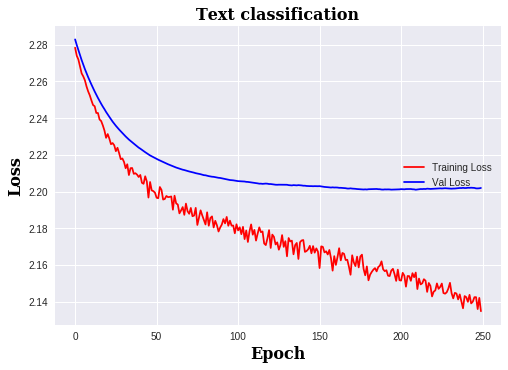

In [35]:
epochs = 250
train_loss_history = []
val_loss_history = []

train_acc_history = []
val_acc_history = []

print("Training for," , epochs , " epochs...")
print("Embeddings dim: ", embedding_dim)
print("Batch size: ", train_batches.dl.batch_size)
print("Hidden size: ", hidden_size)
print("Layers: ", num_layers, "\n")

for epoch in range(1, epochs + 1):
    
    # Training
    train_loss, train_acc = train(model, train_batches, criterion, optimizer)
    
    # Validation
    val_loss, val_acc = validation(model, val_batches, criterion) #(0, 0) OR validation(model, val_batches, criterion)
    
    # Append losses per epoch for plotting
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    
    # Append accuracies per epoch for plotting
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    
    print(f'| Epoch: {epoch:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Valid Loss: {val_loss:.3f} | Valid Acc: {val_acc*100:.2f}%')

# Plot the losses and accuracies
fig = plt.figure(1)
font = {'family' : 'serif', 'color'  : 'black', 'weight' : 'bold', 'size'   : 16,}

ax1 = fig.add_subplot(111)
ln1 = ax1.plot(train_loss_history, 'r', label='Training Loss')
ln2 = ax1.plot(val_loss_history, 'b', label='Val Loss')

lns = ln1+ ln2
labs = [l.get_label() for l in lns]

ax1.legend(lns, labs, loc=7)
ax1.set_ylabel('Loss', fontdict=font)
ax1.set_title("Text classification", fontdict=font)
ax1.set_xlabel('Epoch', fontdict=font)

plt.show()

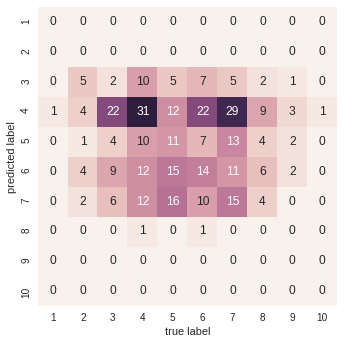

Classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        16
           2       0.05      0.05      0.05        43
           3       0.23      0.41      0.30        76
           4       0.21      0.19      0.20        59
           5       0.19      0.23      0.21        61
           6       0.23      0.21      0.22        73
           7       0.00      0.00      0.00        25
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         1

   micro avg       0.20      0.20      0.20       363
   macro avg       0.09      0.11      0.10       363
weighted avg       0.17      0.20      0.18       363



(2.182190687760063, 0.20110192837465565)

In [39]:
# 250 epochs w/o attention
test(model, val_batches, criterion)

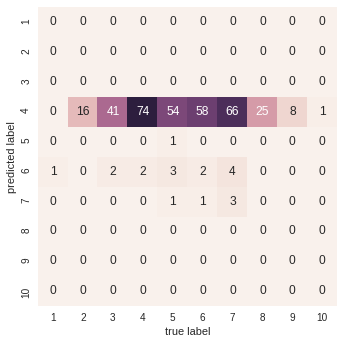

Classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        16
           2       0.00      0.00      0.00        43
           3       0.22      0.97      0.35        76
           4       1.00      0.02      0.03        59
           5       0.14      0.03      0.05        61
           6       0.60      0.04      0.08        73
           7       0.00      0.00      0.00        25
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         1

   micro avg       0.22      0.22      0.22       363
   macro avg       0.20      0.11      0.05       363
weighted avg       0.35      0.22      0.10       363



(2.1938527977984883, 0.22038567493112948)

In [58]:
# 250 epochs with attention
test(model, val_batches, criterion)